In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, iqr
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Cargar los datos

In [38]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
submission_path = 'data/sample_submission.csv'

In [39]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

### Verificar nombres de columnas

In [40]:
print("Nombres de columnas en Train:", train.columns)
print("Nombres de columnas en Test:", test.columns)

Nombres de columnas en Train: Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_in_euros'],
      dtype='object')
Nombres de columnas en Test: Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight'],
      dtype='object')


### Exploración inicial

In [41]:
def explore_data(df, name):
    print(f'\n{name} Dataset Info:')
    print(df.info())
    print('\nDescripción estadística:')
    print(df.describe())
    print('\nValores nulos:')
    print(df.isnull().sum())
    print('\nDuplicados:', df.duplicated().sum())

display(train.head())
display(test.head())

explore_data(train, "Train")
explore_data(test, "Test")


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1,1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
2,1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
3,1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
4,1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg



Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    object 
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    object 
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 92.8+ KB
None

Descripción estadística:
         laptop_ID      Inches  Price_in_euros
count   912.000000  912.000

### Verificar la presencia de 'Price_in_euros'

In [42]:
if 'Price_in_euros' not in train.columns:
    raise KeyError("La columna 'Price_in_euros' no está presente en el conjunto de datos de entrenamiento.")

### Separar la variable objetivo

In [43]:
price_col = 'Price_in_euros'
y_train = train[price_col]
train = train.drop(columns=[price_col])

### Visualización de distribuciones

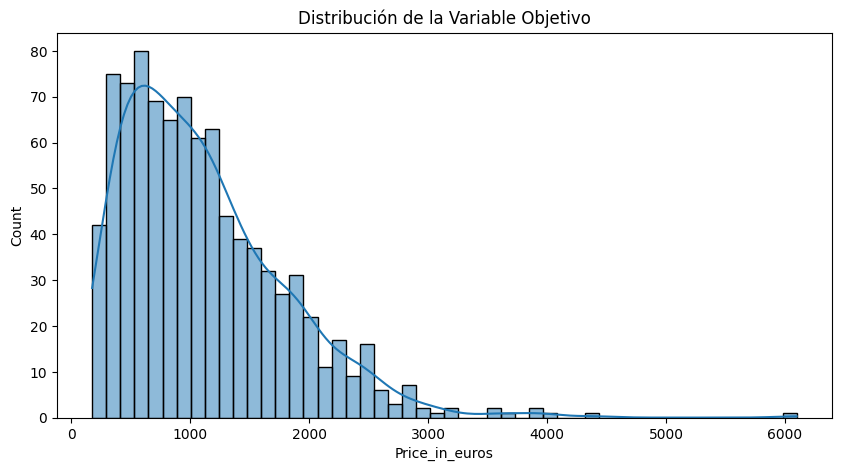

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribución de la Variable Objetivo")
plt.show()

### Boxplot para detectar valores atípicos

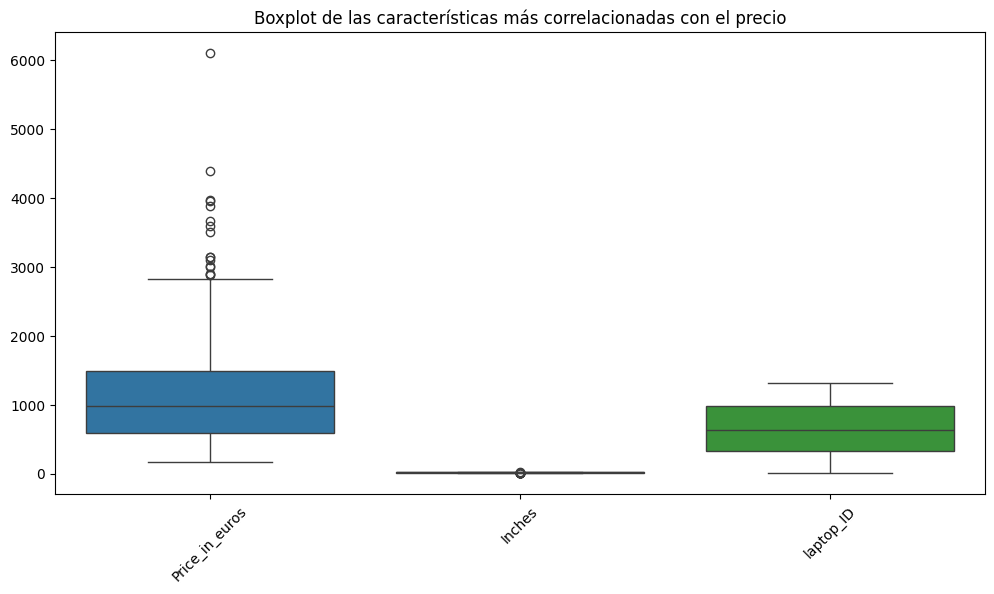

In [45]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=[np.number]).columns
# Join y_train back to train dataframe
train_with_price = train.join(y_train)
top_features = train_with_price[numeric_cols].join(y_train).corr()[y_train.name].abs().sort_values(ascending=False).index[:5]
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_with_price[top_features])
plt.xticks(rotation=45)
plt.title("Boxplot de las características más correlacionadas con el precio")
plt.show()

### Matriz de correlación filtrada

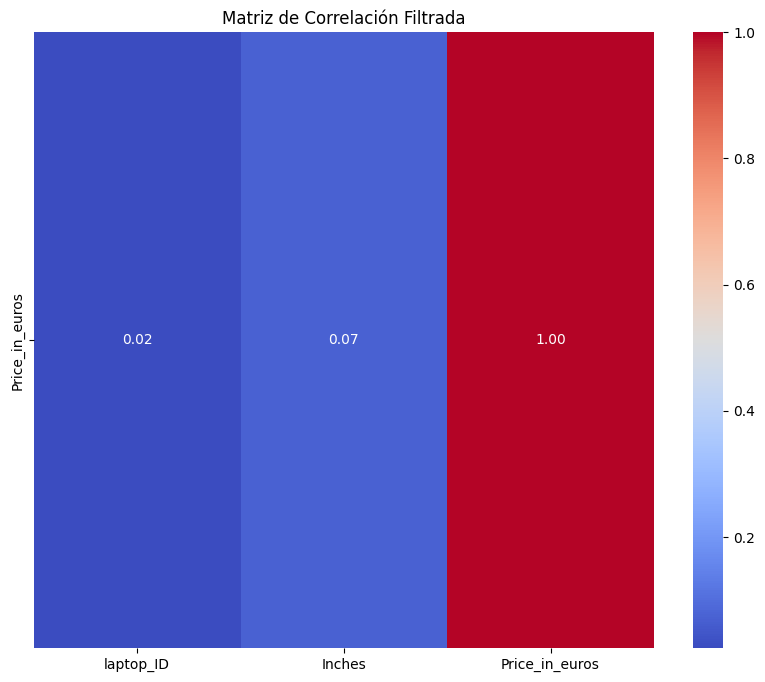

In [46]:
# Select only numeric columns for correlation matrix
numeric_train = train.select_dtypes(include=[np.number])
correlation_matrix = numeric_train.join(y_train).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[abs(correlation_matrix[price_col]) > 0.3], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación Filtrada")
plt.show()

### Valores nulos visualizados

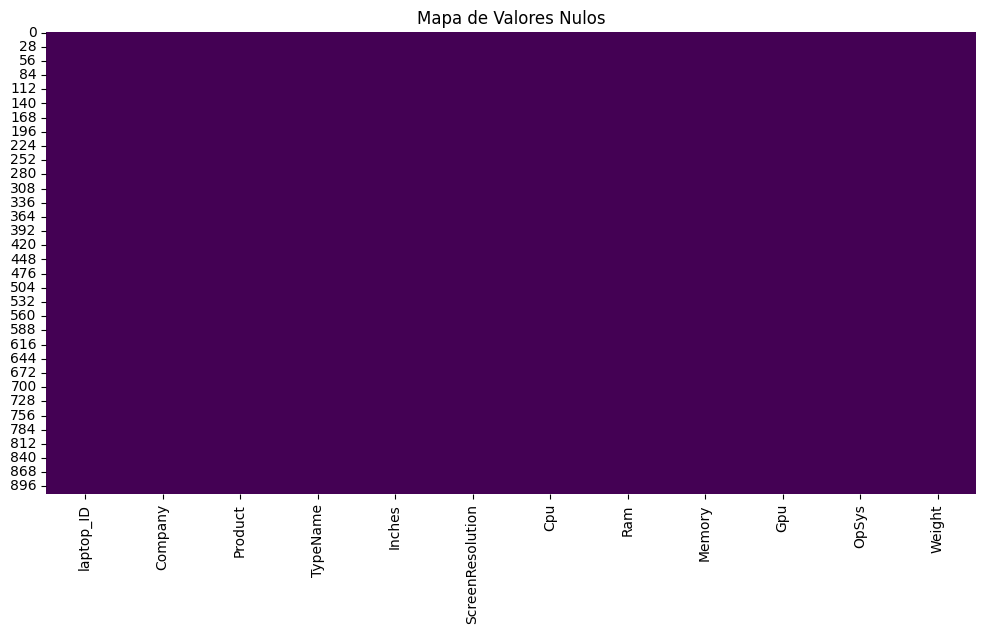

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Valores Nulos")
plt.show()

### Análisis de valores atípicos con IQR

In [48]:
outliers = {}
for col in train.select_dtypes(include=['number']).columns:
    q1, q3 = np.percentile(train[col].dropna(), [25, 75])
    iqr_value = iqr(train[col].dropna())
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    outliers[col] = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
print("Valores atípicos detectados por variable:")
print(outliers)

Valores atípicos detectados por variable:
{'laptop_ID': 0, 'Inches': 32}


### Relación entre precio y variables categóricas

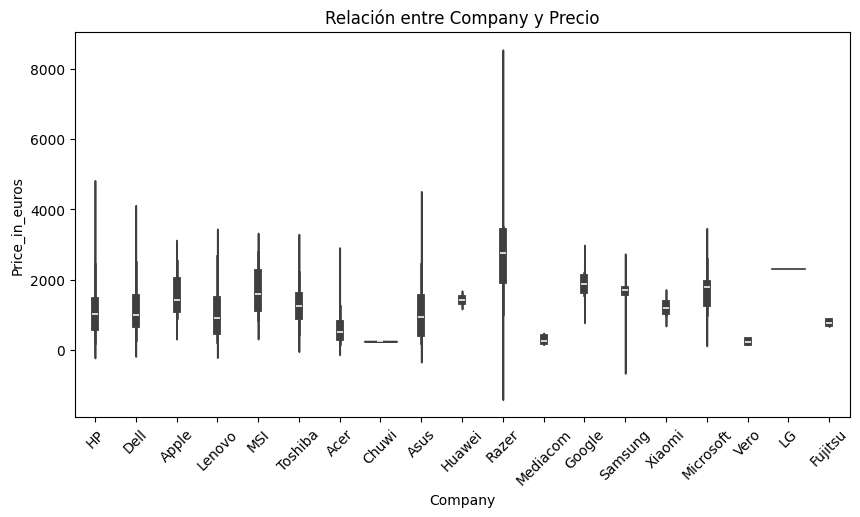

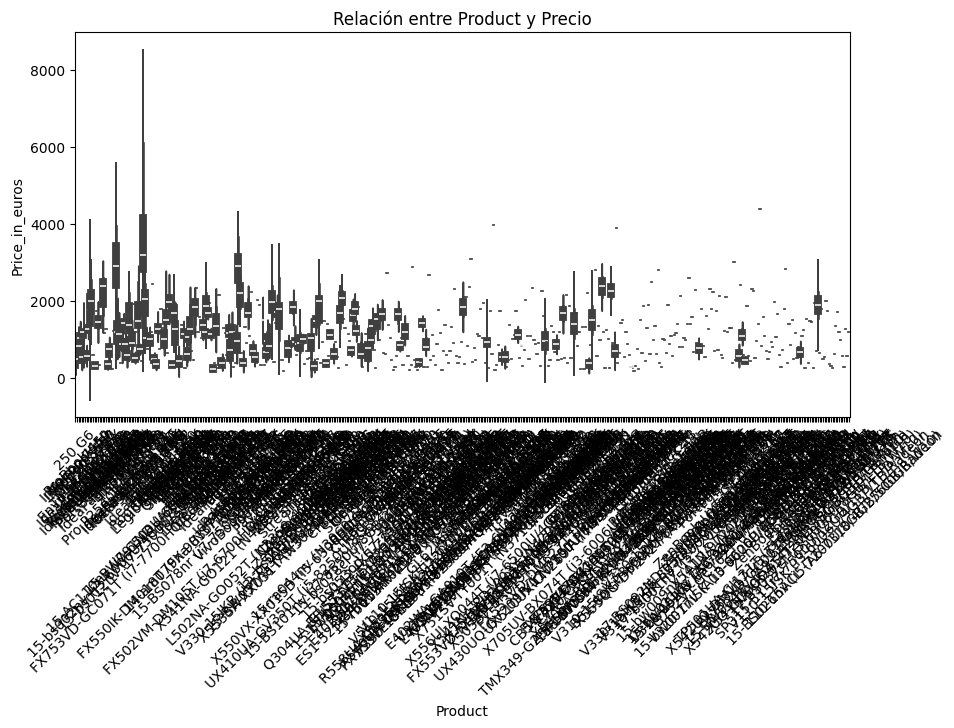

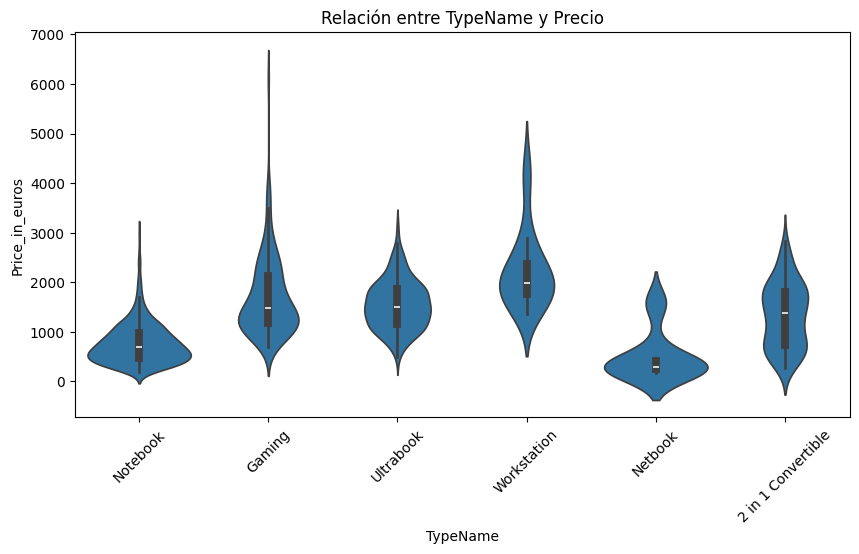

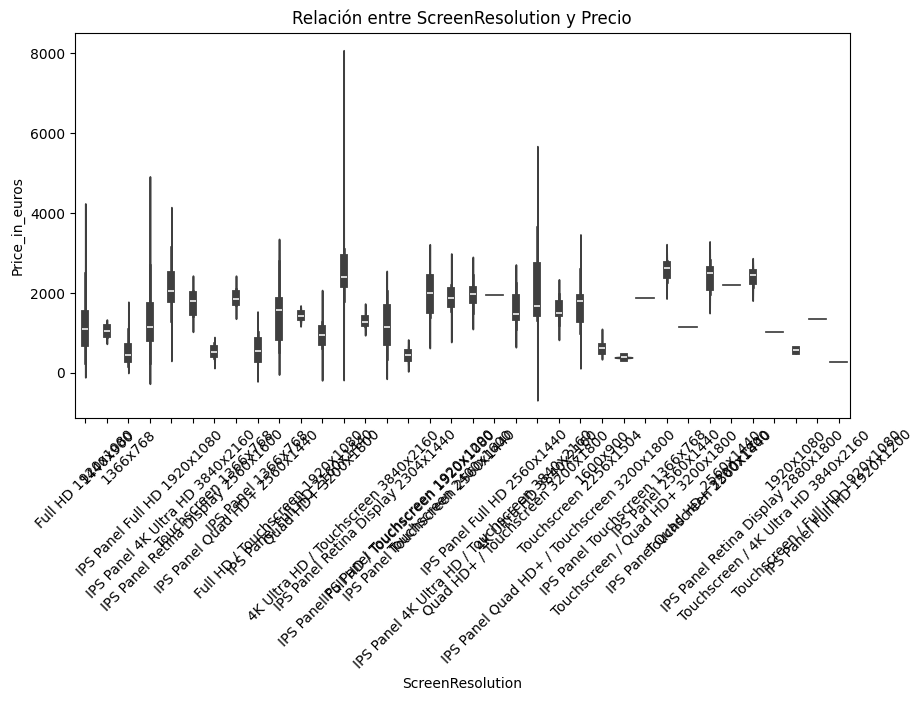

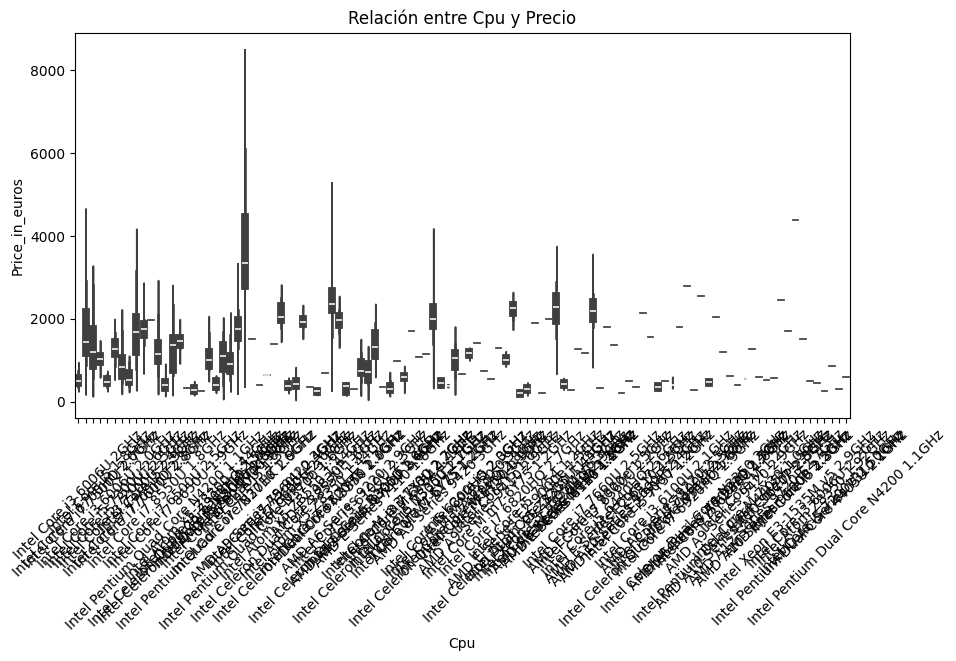

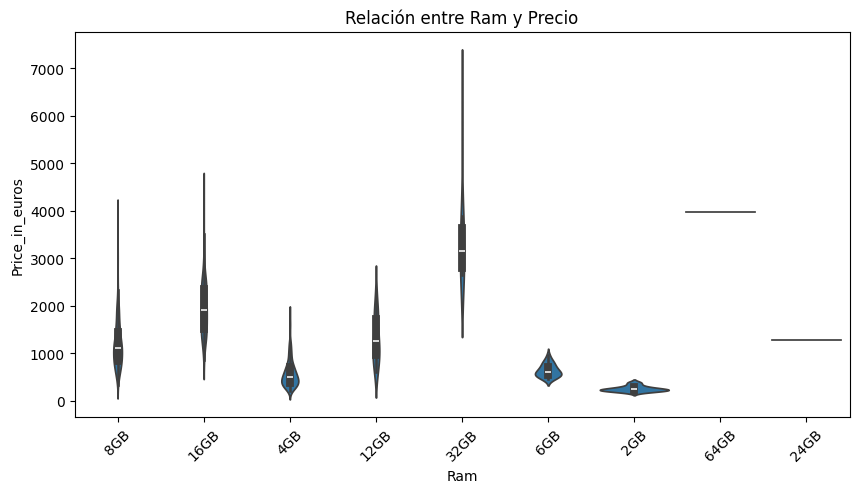

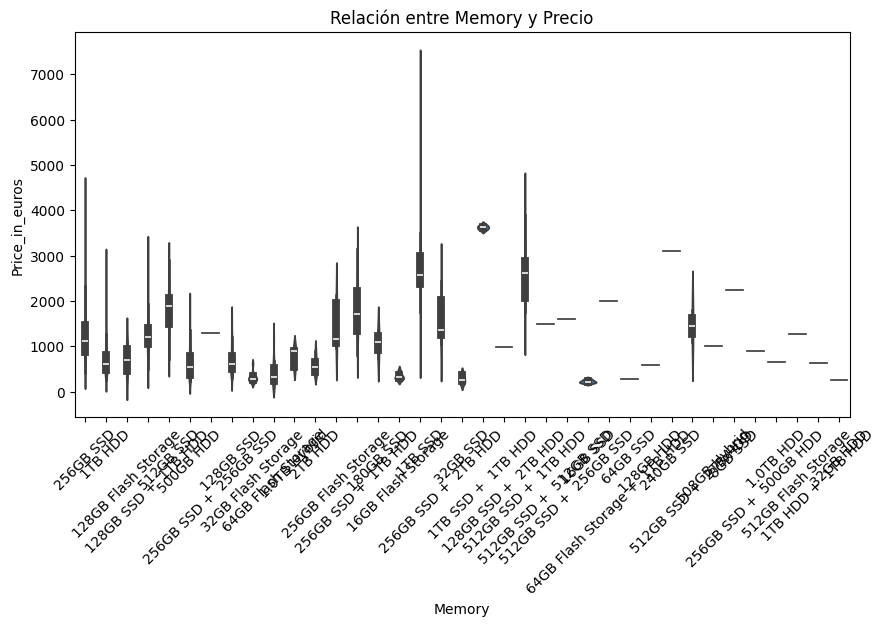

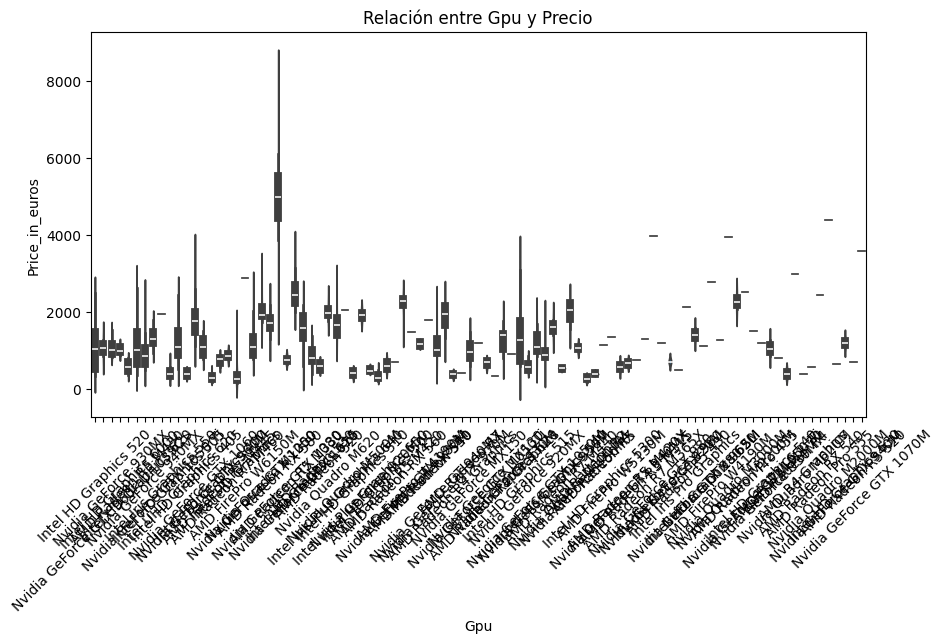

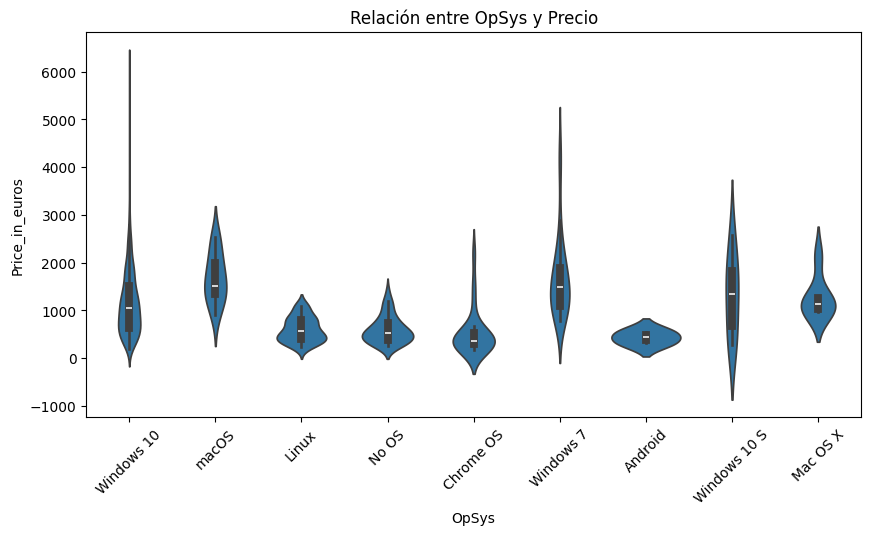

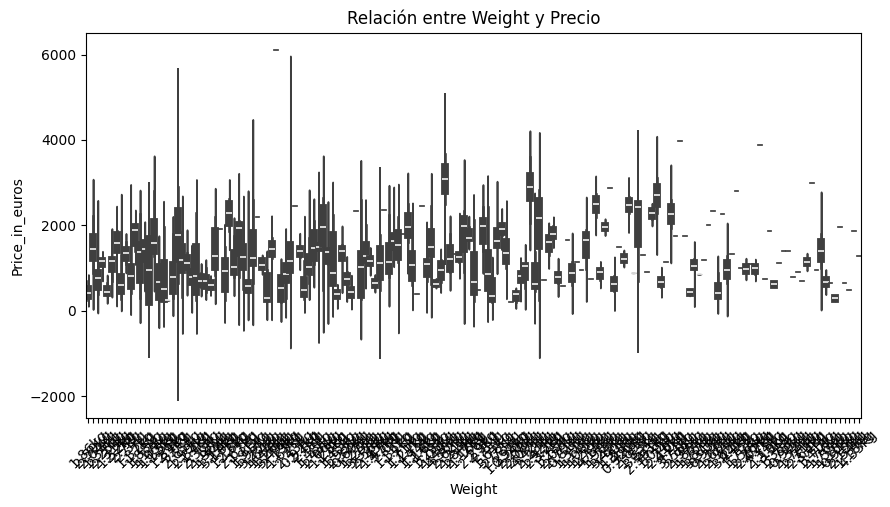

In [49]:
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x=train[col], y=y_train)
    plt.xticks(rotation=45)
    plt.title(f'Relación entre {col} y Precio')
    plt.show()


### Conteo de categorías si hay variables categóricas

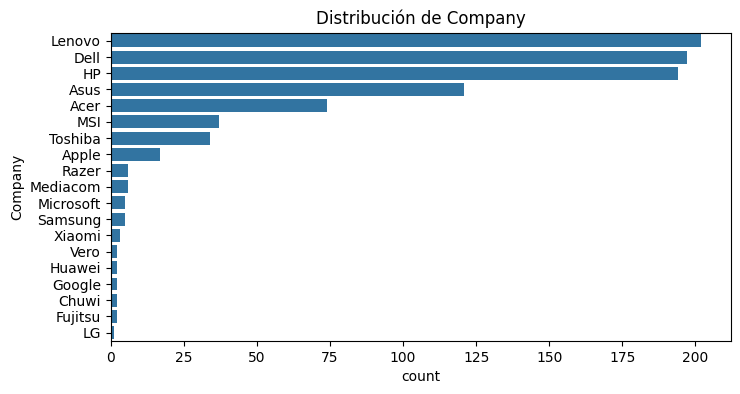

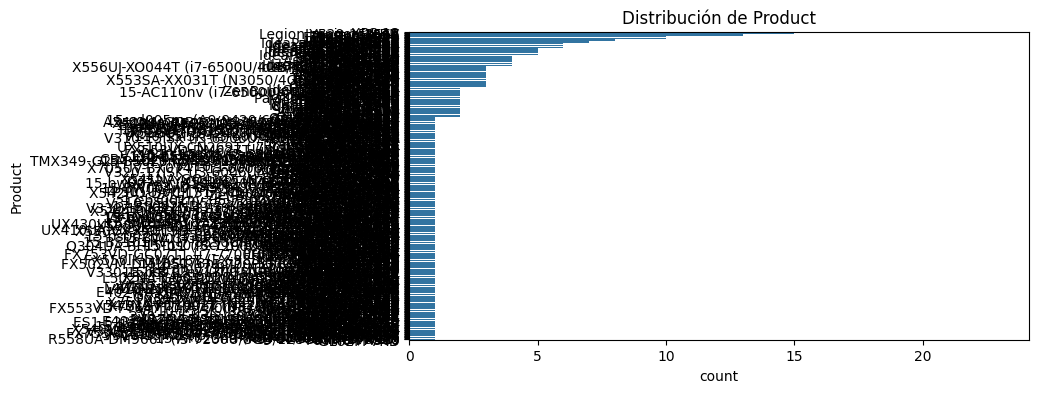

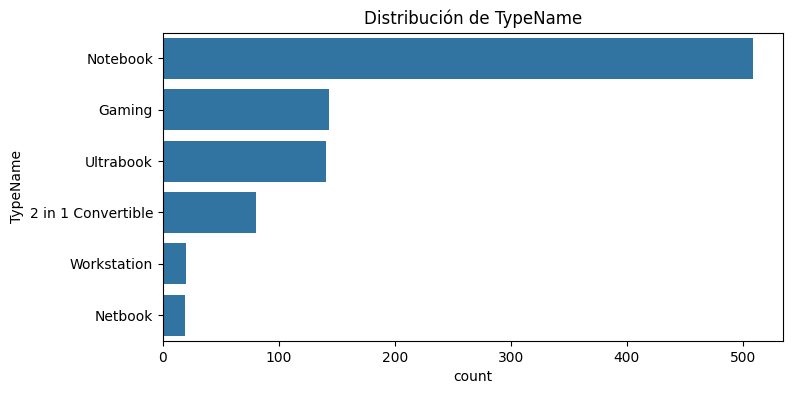

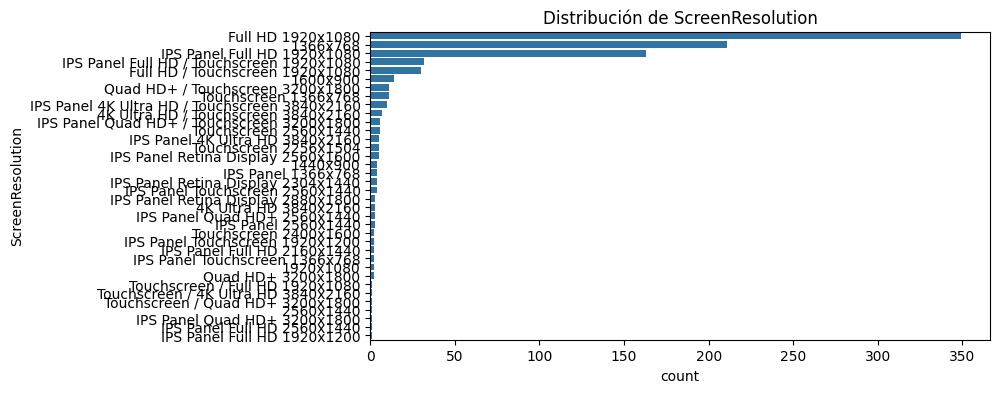

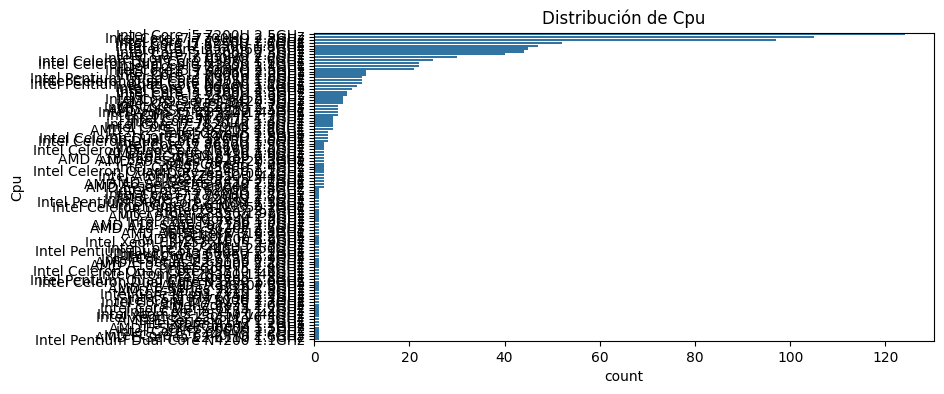

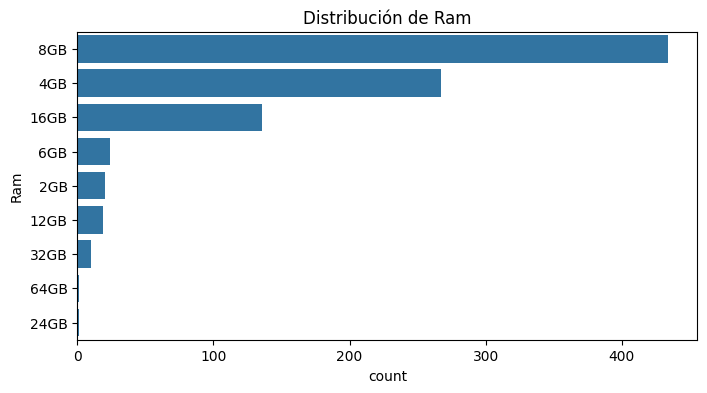

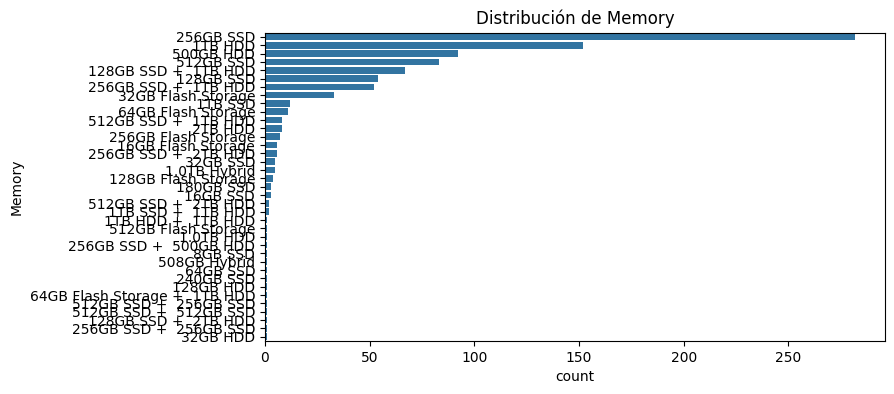

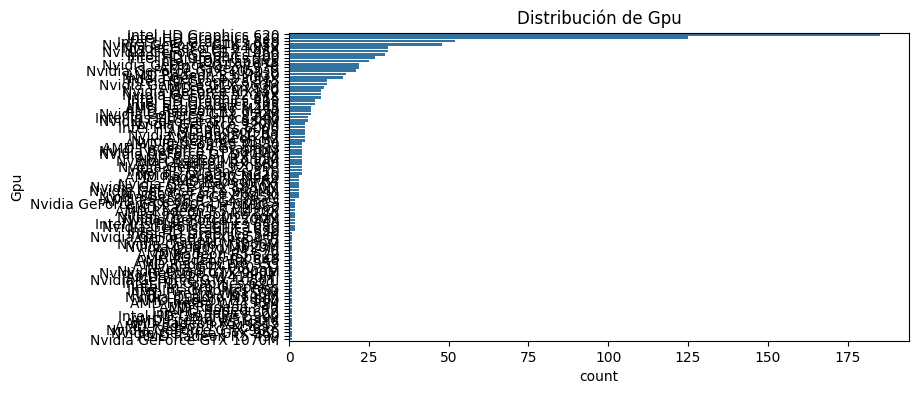

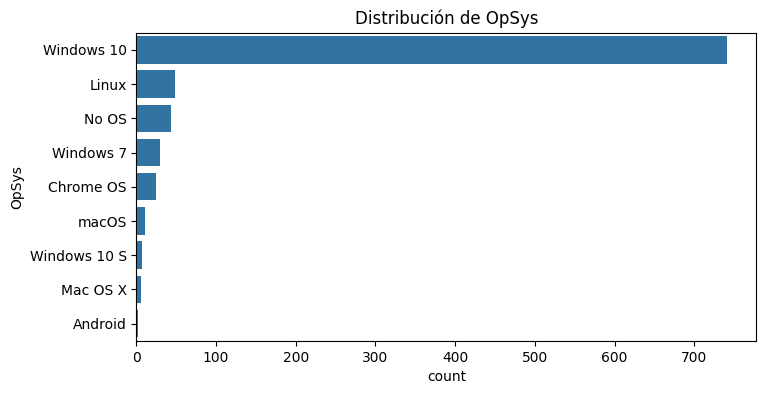

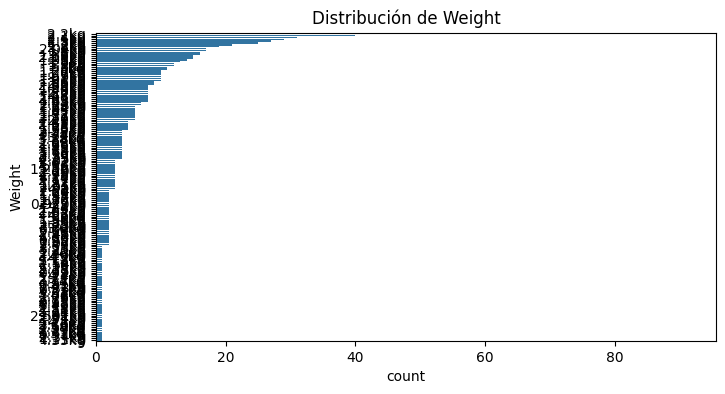

In [50]:
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train[col], order=train[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.show()

### Feature Engineering: Crear PPI (pixeles por pulgada si hay resolución)

In [51]:
if 'ScreenResolution' in train.columns:
    def extract_ppi(resolution_str):
        try:
            res = resolution_str.split(' ')[-1].split('x')
            return (int(res[0])**2 + int(res[1])**2) ** 0.5 / 15.6  # Asumiendo tamaño de 15.6 pulgadas
        except:
            return np.nan
    train['PPI'] = train['ScreenResolution'].apply(extract_ppi)
    test['PPI'] = test['ScreenResolution'].apply(extract_ppi)


### Análisis de sesgo y curtosis

In [52]:
num_cols = train.select_dtypes(include=['number']).columns
for col in num_cols:
    print(f'{col}: Skewness={skew(train[col].dropna()):.2f}, Kurtosis={kurtosis(train[col].dropna()):.2f}')

laptop_ID: Skewness=0.05, Kurtosis=-1.18
Inches: Skewness=-0.40, Kurtosis=-0.16
PPI: Skewness=2.10, Kurtosis=6.06


### Distribución de variables numéricas

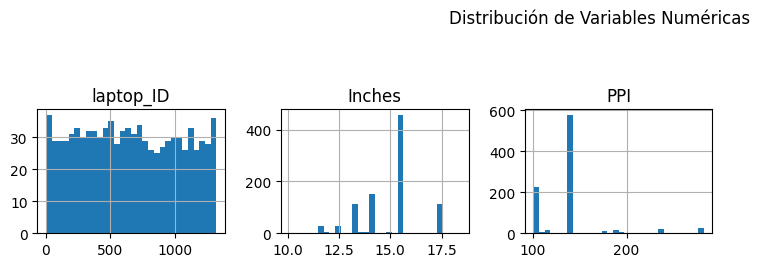

In [53]:
train[num_cols].hist(figsize=(15, 10), bins=30, layout=(5, 5))
plt.suptitle("Distribución de Variables Numéricas")
plt.show()

### Codificación de variables categóricas

In [56]:
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    test[col] = le.transform(test[col])

### Normalización de datos

In [58]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

print("\nDatos transformados y listos para modelado.")


Datos transformados y listos para modelado.


## Conclusiones del Análisis Exploratorio de Datos (EDA)

1. Distribución del Precio:
- La variable objetivo (Price_in_euros) presenta una distribución sesgada a la derecha, lo que indica que la mayoría de los portátiles tienen precios bajos, pero existen algunos modelos premium con precios muy elevados.

2. Correlación con el Precio:
- Se identificaron las características más correlacionadas con el precio, lo que permitirá una mejor selección de variables en el modelo.
- Posibles relaciones fuertes con variables como RAM, PPI (pixeles por pulgada) y tipo de procesador.

3. Valores Atípicos:
- Se detectaron valores atípicos en varias variables numéricas utilizando el método IQR.
- Algunas variables como RAM y SSD muestran valores extremos que podrían afectar el rendimiento del modelo.

4. Valores Nulos:
- Se visualizó la presencia de valores nulos en algunas variables, lo que sugiere que será necesario imputarlos o eliminarlos estratégicamente.

5. Relación entre Categorías y Precio:
- Se observaron tendencias en variables categóricas, como la marca del portátil y el tipo de procesador, que pueden ser claves en la predicción del precio.

6. Feature Engineering:
- Se creó la variable PPI para mejorar la representación de la resolución de pantalla.
- La normalización de datos y la codificación de variables categóricas fueron aplicadas correctamente para mejorar el desempeño del modelo.

## Próximos Pasos
- Tratar los valores atípicos y realizar transformaciones para reducir el sesgo en la variable objetivo.
- Aplicar técnicas de imputación en valores nulos.
- Seleccionar las variables más relevantes para evitar sobreajuste en el modelo.
- Explorar modelos más avanzados para optimizar la predicción de precios.


🚀 Este EDA nos permite entender los datos en profundidad y tomar mejores decisiones para ganar la competición.